In [45]:
import os
import pandas as pd
import itertools
from datetime import datetime
import plotly.express as px

In [2]:
def read_raw_table(table_path):
    r = pd.read_excel(table_path, skiprows = 28, index_col = 0)
    
    df = r.loc[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], :]
    df.index.name = None
    
    t = r.loc["End Time:", 1]
    t = datetime_object = datetime.strptime(t, '%d/%m/%Y %H:%M:%S')
    
    return df, t

In [3]:
wells = [f"{i[1]}{i[0]}" for i in itertools.product(range(1, 13), ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])]

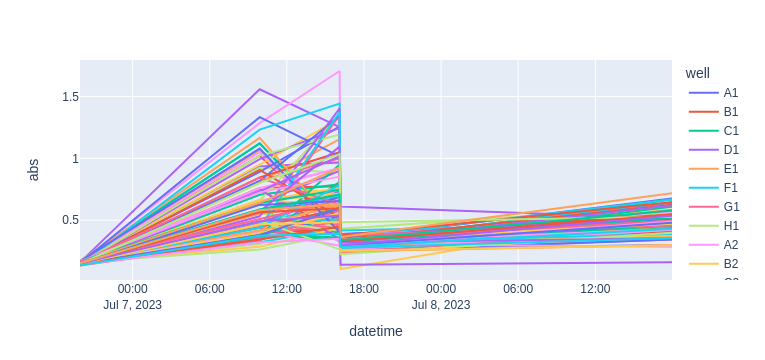

In [48]:
plate = "plate01"

ml = []
for well in wells:
    vals = []
    ts = []
    for table_file in sorted(os.listdir(f"OD_readings/{plate}")):
        table_path = f"OD_readings/{plate}/{table_file}"
        df, t = read_raw_table(table_path)
        t = t.strftime('%Y-%m-%d %H:%M:%S')
        ts.append(t)
        val = df.loc[well[0], int(well[1:])]
        vals.append(val)
    for i in list(zip([well]*len(vals), vals, ts)):
        ml.append(list(i))


df = pd.DataFrame(ml)
df.columns = ["well", "abs", "datetime"]

px.line(df, x = "datetime", y = "abs", color = "well")

In [52]:
%load_ext watermark
%watermark -v -m -p pandas,plotly,openpyxl
print()
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.12.0

pandas  : 1.5.1
plotly  : 5.11.0
openpyxl: 3.0.10

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.15.0-76-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit


Last updated: Sun Jul 09 2023 13:59:30+08

